# Country search trends

Previously, we measured Americans' expectations about how many casualties occurred during disasters in different countries. But there are many factors that might go into these judgments. Some might be general predictive properties--population, distance from the USA, etc.--but others might be more idiosyncratic--recent conflicts, actual earthquake baserates, etc. Here, we're going to try to identify some general predictors using Google trends data. To figure out good predictors, we're going to see how much countries care about each other as measured by how much they Google each other.

Our measure for how much one Country A cares about Country B is going to be the log10 ratio of how much Country A searches for Country B divided by how much Country B searches for Country B. For example, [this search](https://www.google.com/trends/explore#q=%2Fm%2F0f8l9c%2C%20%2Fm%2F09c7w0&geo=US&date=1%2F2005%20133m&cmpt=q&tz=Etc%2FGMT%2B7) is going to allow us to see how much Americans care about the French. If we look at the summary bar graph, we're going to take log10(5/79). So, rule of thumb, less negative scores indicate the country is more searched.

In [57]:
%matplotlib inline

import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from geopy.distance import vincenty
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(style="white", color_codes=True)

In [310]:
# The lm code keeps setting off errors, but doesn't seem to be affecting anything
import warnings

# http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/mixed_lm_example.html
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = mdf.profile_re(0, dist_low=0.00001, dist_high=0.1)

Let's read the raw data into a csv

In [2]:
trends_df=pd.read_csv('country_trends.csv',header=None)
trends_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,NaN,Nigeria,Japan,Pakistan,United States,France,Russia,Indonesia,Mexico,Rwanda,...,Germany,Spain,Thailand,South Africa,India,Australia,Brazil,Canada,Belgium,Netherlands
1,Nigeria,68,1,0,14,2,1,0,0,0,...,2,1,0,3,2,2,1,5,1,1
2,Japan,0,66,1,16,3,2,4,3,0,...,2,2,3,2,3,4,8,2,1,1
3,Pakistan,0,1,70,4,0,1,0,0,0,...,1,0,1,0,5,2,0,2,0,0
4,United States,1,6,2,80,5,5,1,14,0,...,5,4,2,2,9,6,8,12,1,1


And now let's turn it into our country caring measure

In [3]:
self_df=pd.DataFrame({'self_num':[int(trends_df.iloc[i,i]) for i in range(1,41)],
 'Searcher':[trends_df.iloc[0,i] for i in range(1,41)]})

In [120]:
searcher=[]
searchee=[]
search_num=[]
for s_er in range(1,41):
    for s_ee in range(1,41):
        if s_er!=s_ee:
            searcher.append(trends_df.iloc[s_er,0])
            searchee.append(trends_df.iloc[0,s_ee])        
            search_num.append(int(trends_df.iloc[s_er,s_ee]))
search_df=pd.DataFrame({'Searcher':searcher,'Searchee':searchee,'search_num':search_num})
search_df=pd.merge(search_df,self_df,how='inner',on='Searcher')

count_2= (search_df.loc[:,'search_num']+(search_df.loc[:,'self_num']/(100)))
norm_2= (search_df.loc[:,'self_num']+(search_df.loc[:,'self_num']/(100)))
search_df.loc[:,'search_score']=np.log10(count_2/norm_2)
search_df.head()

,Searchee,Searcher,search_num,self_num,search_score
0,Japan,Nigeria,1,68,-1.611521
1,Pakistan,Nigeria,0,68,-2.004321
2,United States,Nigeria,14,68,-0.670104
3,France,Nigeria,2,68,-1.408695
4,Russia,Nigeria,1,68,-1.611521


Ok, first analysis--What countries were searched the most?

In [121]:
mean_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').mean().reset_index()
mean_searchee.columns=['Searchee', 'mean']
std_searchee=search_df.loc[:,['Searchee','search_score']].groupby('Searchee').std()
num_search=np.sqrt(search_df.loc[:,['Searchee','search_score']].groupby('Searchee').size())
sem_searchee=std_searchee.divide(num_search,axis=0).reset_index()
sem_searchee.columns=['Searchee', 'SEM']

searchee_df=pd.merge(mean_searchee,sem_searchee,how='inner',on='Searchee')
searchee_df=searchee_df.sort_values(by='mean').reset_index()

In [122]:
searchee_df

,index,Searchee,mean,SEM
0,20,Liberia,-2.004321,0.000000
1,12,Haiti,-1.995291,0.009030
2,29,Rwanda,-1.984597,0.019724
3,39,Yemen,-1.969791,0.024906
4,26,North Korea,-1.963354,0.024140
5,22,Nepal,-1.931742,0.028782
6,0,Afghanistan,-1.899238,0.032266
7,38,Venezuela,-1.892080,0.040410
8,19,Jordan,-1.877866,0.035829
9,14,Indonesia,-1.869191,0.044479


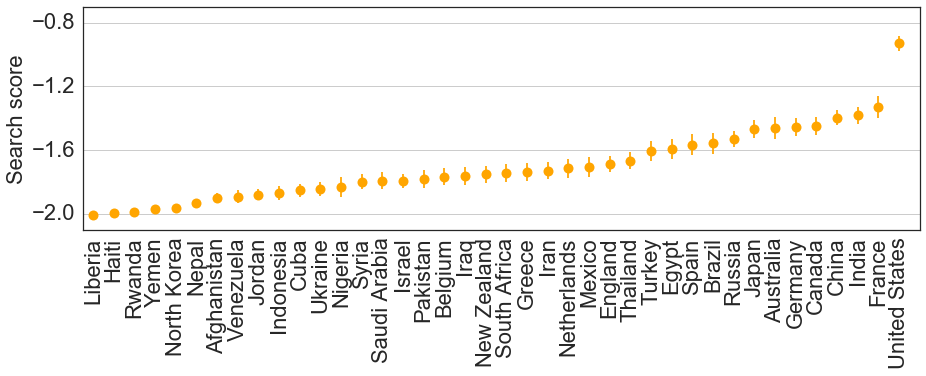

In [344]:
plt.figure(figsize=(15,4))
ax=plt.axes()
ax.yaxis.grid(True)
plt.errorbar(range(len(searchee_df)), searchee_df['mean'], yerr=searchee_df['SEM'],\
             c='orange',fmt='o',markersize=10)

plt.ylabel('Search score',fontsize='22')
plt.xticks(range(len(searchee_df)), searchee_df['Searchee'], rotation='90',fontsize=22)
plt.yticks([-2,-1.6,-1.2,-.8],fontsize=22)
plt.axis([-.5, len(searchee_df), -2.1, -.7])
plt.show()

# Country by Country Analyses

So far we've seen that certain countries are searched more often (more "popular" we might say) overall. How do these patterns vary depending on what country is doing the searching?

In [189]:
search_mat=search_df.pivot('Searchee','Searcher','search_score')
search_mat2=search_mat.loc[list(searchee_df['Searchee']),list(searchee_df['Searchee'])]
search_mat2.head()

Searcher,Liberia,Haiti,Rwanda,Yemen,North Korea,Nepal,Afghanistan,Venezuela,Jordan,Indonesia,...,Brazil,Russia,Japan,Australia,Germany,Canada,China,India,France,United States
Searchee,,,,,,,,,,,,,,,,,,,,,
Liberia,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
Haiti,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-1.652139
Rwanda,-1.235088,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
Yemen,-2.004321,-2.004321,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321
North Korea,-2.004321,-2.004321,-2.004321,-2.004321,NaN,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,...,-2.004321,-2.004321,-1.260384,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-2.004321,-1.652139


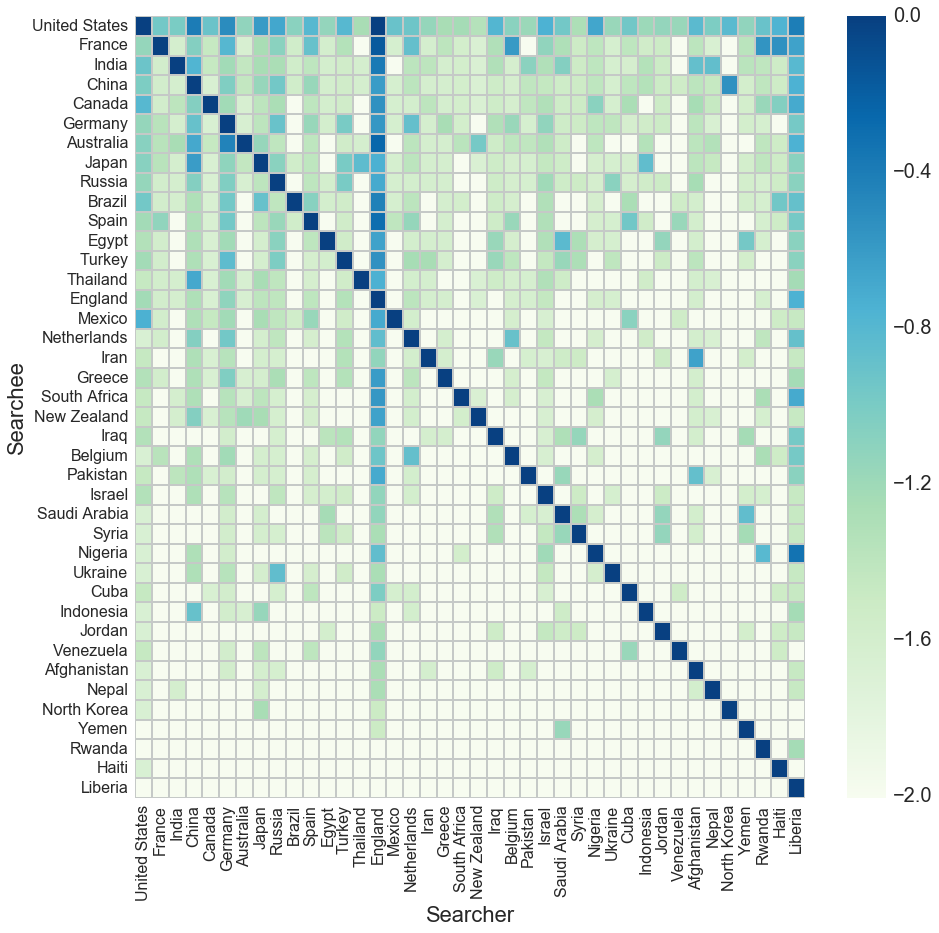

In [340]:
search_mat=search_df.pivot('Searchee','Searcher','search_score')
search_mat2=search_mat.loc[list(searchee_df['Searchee'])[::-1],list(searchee_df['Searchee'])[::-1]]
for i in range(0,40):
    search_mat2.iloc[i,i]=0 # Setting self-search to the max

plt.figure(figsize=(15,14))
#plt.figure(figsize=(4,4))
hm=sns.heatmap(search_mat2, linewidths=1,linecolor='#c5c9c7',vmax=0,cmap="GnBu")
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=20)
xt=plt.xticks(fontsize=16)
yt=plt.yticks(fontsize=16)
xl=plt.xlabel('Searcher',fontsize='22')
yl=plt.ylabel('Searchee',fontsize='22')


In [206]:
# search_mat=search_df.pivot('Searchee','Searcher','search_score')

# for i in range(0,40):
#     search_mat.iloc[i,i]=0 # Setting self-search to the max
# sns.set(font_scale=1.75)

# g=sns.clustermap(search_mat, linewidths=1,linecolor='#c5c9c7', figsize=(15.5,15.5),vmax=0,cmap="GnBu")
# g2=g.ax_heatmap
# y_labels=g2.set_yticklabels(g2.get_yticklabels(),rotation=0)
# g.ax_col_dendrogram.remove()
# g.ax_row_dendrogram.remove()
# sns.set(style="white", color_codes=True) # Something in clustermap seems to override the set()

# Correlation with casualty estimates
Let's see how these results compare to our casualty results

In [207]:
countries=['Nigeria','Japan','Pakistan','United States','France','Russia', \
          'Indonesia','Mexico','Rwanda','Haiti','Jordan','Cuba', \
          'Liberia','North Korea','Syria','Iraq','Yemen','Ukraine', \
          'Afghanistan','Turkey','Venezuela','Egypt','Iran','Saudi Arabia', \
          'China','Israel','Greece','Nepal','England','New Zealand', \
          'Germany','Spain','Thailand','South Africa','India','Australia', \
          'Brazil','Canada','Belgium','Netherlands'] # These are mapped onto art_id in our dataset

casualty_df=pd.read_csv('../pilot_survey_v2/mturk_data_itNews_v3.csv', quotechar="'",header=None,usecols=[5,9,10,11,12,])
casualty_df.columns=['true_country','true_casualties','resp_country','resp_poster','resp_casualties']

casualty_df.loc[:,'true_casualties_log10']=np.log10(casualty_df.loc[:,'true_casualties'])
casualty_df.loc[:,'resp_casualties_log10']=np.log10(casualty_df.loc[:,'resp_casualties'])

casualty_df.loc[:,'true_name']=casualty_df.loc[:,'true_country'].apply(lambda x:countries[x])
casualty_df=casualty_df.loc[:,['true_name','resp_casualties_log10']]

In [208]:
mean_casualty=casualty_df.groupby('true_name').mean().reset_index()
std_casualty=casualty_df.groupby('true_name').std()
num_casualty=np.sqrt(casualty_df.loc[:,['true_name','resp_casualties_log10']].groupby('true_name').size())

sem_searchee=std_casualty.divide(num_casualty,axis=0).reset_index()
country_casualty=pd.merge(mean_casualty,sem_searchee,on='true_name')
country_casualty.columns=['true_name','mean_cas','SEM_cas']

searchee_df2=pd.merge(searchee_df,country_casualty,left_on='Searchee',right_on='true_name')
del searchee_df2['true_name']

print searchee_df2.head()

   index     Searchee      mean       SEM  mean_cas   SEM_cas
0     20      Liberia -2.004321  0.000000  1.742051  0.170930
1     12        Haiti -1.995291  0.009030  2.689742  0.175097
2     29       Rwanda -1.984597  0.019724  2.591224  0.142209
3     39        Yemen -1.969791  0.024906  2.355522  0.140432
4     26  North Korea -1.963354  0.024140  2.285098  0.127236


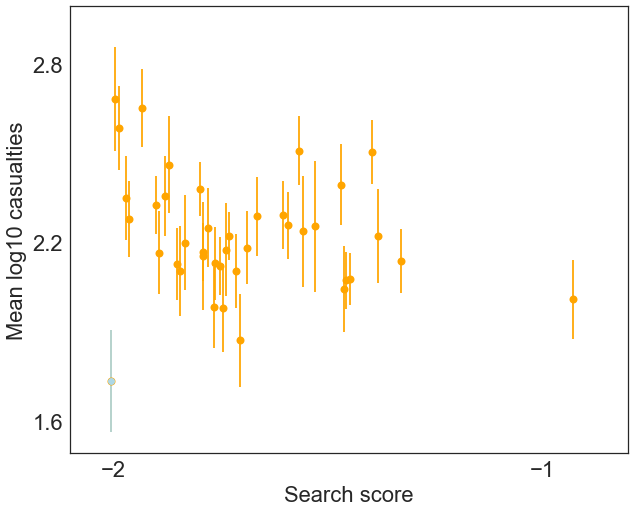

In [337]:
plt.figure(figsize=(10,8))

plt.errorbar(searchee_df2['mean'], searchee_df2['mean_cas'], yerr=searchee_df2['SEM_cas'],\
             c='orange',fmt='o',markersize=8)

# liberia
liberia_df=searchee_df2[searchee_df2['Searchee']=='Liberia']
plt.errorbar(liberia_df['mean'], liberia_df['mean_cas'], yerr=liberia_df['SEM_cas'],c='lightblue',fmt='o')

plt.xlabel('Search score',fontsize='22')
plt.ylabel('Mean log10 casualties',fontsize='22')
#plt.xticks(range(len(searchee_df)), searchee_df['searchee'], rotation='90',fontsize=22)
plt.xticks([-2,-1],fontsize=22)
plt.yticks([1.6,2.2,2.8],fontsize=22)
plt.axis([-2.1, -.8, 1.5, 3])
plt.show()


I made Liberia blue here (bottom-left). It's a weird case--It's rarely searched and in our casualty results people seem to assume it's a small island.

In [210]:
not_liberia_df=searchee_df2[searchee_df2['Searchee']!='Liberia'] # exclude liberia because it's an outlier

a,b=stats.pearsonr(not_liberia_df['mean'], not_liberia_df['mean_cas'])  
print a
print b

-0.338801273962
0.0348738184654


Okay, cool! There's a reasonable negative correlation between how often people search a country (marginalized across countries) and how many casualties Americans expect. This bodes well for us trying to find meaningful predictors. We can also look at just Americans' search patterns

In [211]:
searchee_usa_df=pd.merge(search_df.loc[search_df.Searcher=='United States'],country_casualty,left_on='Searchee',right_on='true_name')
searchee_usa_df.head()

,Searchee,Searcher,search_num,self_num,search_score,true_name,mean_cas,SEM_cas
0,Nigeria,United States,1,80,-1.652139,Nigeria,2.206482,0.159948
1,Japan,United States,6,80,-1.074902,Japan,2.400800,0.135751
2,Pakistan,United States,2,80,-1.460253,Pakistan,2.256767,0.132632
3,France,United States,5,80,-1.143983,France,2.144102,0.108619
4,Russia,United States,5,80,-1.143983,Russia,2.260736,0.219207


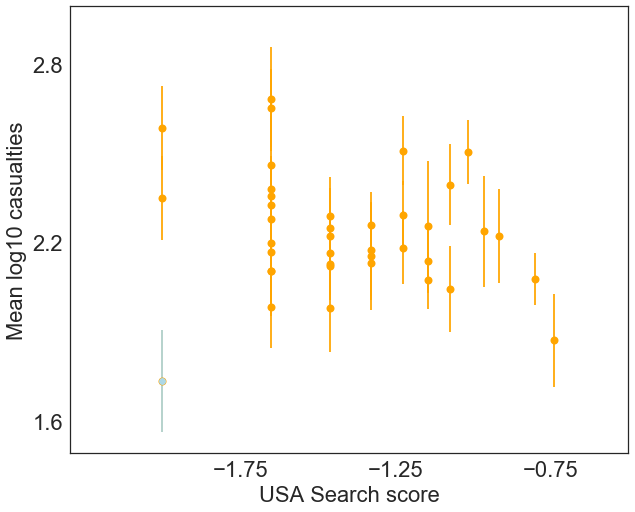

In [371]:
plt.figure(figsize=(10,8))

plt.errorbar(searchee_usa_df['search_score'], searchee_usa_df['mean_cas'], yerr=searchee_usa_df['SEM_cas'],\
             c='orange',fmt='o',markersize=8)
a
# liberia
liberia_df=searchee_usa_df[searchee_usa_df['Searchee']=='Liberia']
plt.errorbar(liberia_df['search_score'], liberia_df['mean_cas'], yerr=liberia_df['SEM_cas'],c='lightblue',fmt='o')

plt.xlabel('USA Search score',fontsize='22')
plt.ylabel('Mean log10 casualties',fontsize='22')
#plt.xticks(range(len(searchee_df)), searchee_df['searchee'], rotation='90',fontsize=22)
plt.xticks([-1.75,-1.25,-.75],fontsize=22)
plt.yticks([1.6,2.2,2.8],fontsize=22)
plt.axis([-2.3, -.5, 1.5, 3])
plt.show()

In [213]:
not_liberia_df=searchee_usa_df[searchee_usa_df['Searchee']!='Liberia'] # exclude liberia because it's an outlier
a,b=stats.pearsonr(not_liberia_df['search_score'], not_liberia_df['mean_cas'])  
print a
print b

-0.365340716754
0.0241031539299


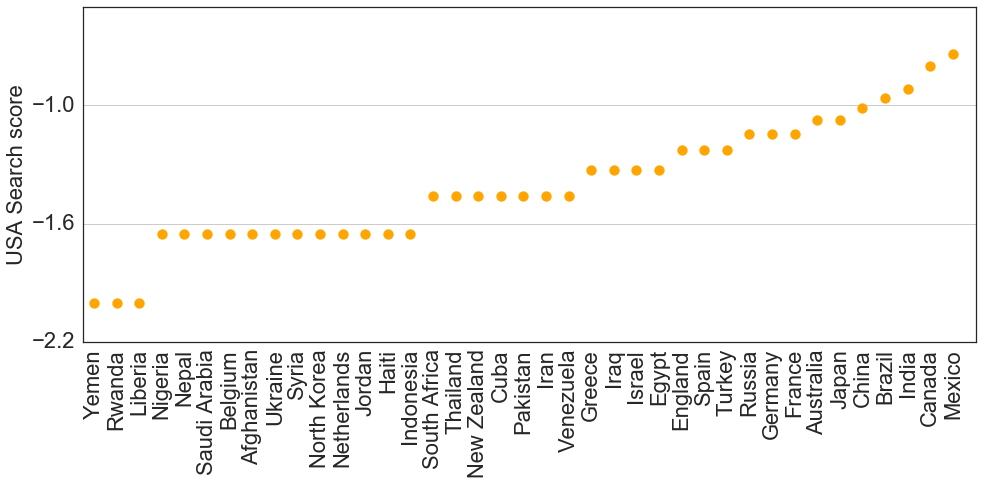

In [370]:
sort_usa= searchee_usa_df.sort_values(by='search_score')
plt.figure(figsize=(16,6))

plt.scatter(range(len(sort_usa['search_score'])), sort_usa['search_score'],\
             color='orange',s=100)


plt.ylabel('USA Search score',fontsize='22')
plt.xticks(range(len(sort_usa)), sort_usa['Searchee'], rotation='90',fontsize=22)

plt.yticks([-2.2,-1.6,-1.0],fontsize=22)
ax=plt.axes()
ax.yaxis.grid(True)
plt.axis([-.5, len(sort_usa), -2.2, -.5])
plt.show()

# Predictors

What factors predict what countries people search for? Drew Walker and I have already collected some data. First we have some demographic and location data from Wikipedia

In [214]:
wiki_df=pd.read_csv('wiki_facts.csv')
wiki_df.head()

,Country,Area (km),Population,Life Expectancy,GDP (per capita PPP),Religion1,Religion2,Language1,Language2,Latitude,Longitude
0,NORTH KOREA,120538,24983205,70.11,1800,Buddhism,Confucianism,Korean,NaN,39.0392,125.7625
1,SYRIA,185180,17064854,74.69,5100,Islam,NaN,Arabic,NaN,33.5138,36.2765
2,IRAN,1648195,81824270,71.15,17800,Islam,NaN,Farsi,NaN,35.6892,51.3890
3,IRAQ,438317,37056169,74.85,15500,Islam,NaN,Arabic,NaN,33.3128,44.3615
4,AFGHANISTAN,652230,32564342,50.87,2000,Islam,NaN,Farsi,NaN,34.5553,69.2075


And some trade information from [the Observatory of Economic Complexity](http://atlas.media.mit.edu/en/resources/data/). Note, you'll have to follow the link for the tsv; it was too large to upload to Github :/

In [215]:
trade_df=pd.read_csv('year_origin_destination_hs07_4.tsv',delimiter='\t')
country_codes={'nigeria':'nga','japan':'jpn','pakistan':'pak','united states':'usa','france':'fra','russia':'rus', 'indonesia':'idn','mexico':'mex','rwanda':'rwa','haiti':'hti','jordan':'jor','cuba':'cub', 'liberia':'lbr','north korea':'prk','syria':'syr','iraq':'irq','yemen':'yem','ukraine':'ukr', 'afghanistan':'afg','turkey':'tur','venezuela':'ven','egypt':'egy','iran':'irn','saudi arabia':'sau', 'china':'chn','israel':'isr','greece':'grc','nepal':'npl','england':'gbr','new zealand':'nzl', 'germany':'deu','spain':'esp','thailand':'tha','south africa':'zaf','india':'ind','australia':'aus', 'brazil':'bra','canada':'can','belgium':'bel','netherlands':'nld'}
trade_df.head()

,year,origin,destination,$prod_id,export_val,import_val
0,2008,abw,are,2710,NaN,7621.0
1,2008,abw,are,8517,NaN,222708.0
2,2008,abw,arg,201,NaN,157715.0
3,2008,abw,arg,202,NaN,1044521.0
4,2008,abw,arg,204,NaN,66372.0


Let's add some factors to our data

In [216]:
unidir_data=wiki_df.loc[:,['Country','Population','GDP (per capita PPP)']]

# the wiki_facts.csv data uses uppercase
search_df.loc[:,'Searchee_upper']=[i.upper() for i in search_df.loc[:,'Searchee']] 
search_df.loc[:,'Searcher_upper']=[i.upper() for i in search_df.loc[:,'Searcher']] 
search_pred_df=pd.merge(search_df,unidir_data,\
                        left_on='Searchee_upper',right_on='Country')
search_pred_df.drop(['Country','search_num','self_num'], axis=1, inplace=True)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP)
0,Japan,Nigeria,-1.611521,JAPAN,NIGERIA,126919659,38200
1,Japan,Pakistan,-1.618970,JAPAN,PAKISTAN,126919659,38200
2,Japan,United States,-1.074902,JAPAN,UNITED STATES,126919659,38200
3,Japan,France,-1.367499,JAPAN,FRANCE,126919659,38200
4,Japan,Russia,-1.088058,JAPAN,RUSSIA,126919659,38200


And let's add in a factor for shared religion

In [217]:
def comp_rel(x):
    s_ee_rel= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Religion1','Religion2']].iloc[0,:]
    s_er_rel= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Religion1','Religion2']].iloc[0,:]
    return len(set(s_ee_rel).intersection(set(s_er_rel)))>0

search_pred_df.loc[:,'com_rel']=search_pred_df.apply(comp_rel,axis=1)
print search_pred_df.query('com_rel==True').head()
print search_pred_df.query('com_rel==False').head()

    Searchee     Searcher  search_score Searchee_upper Searcher_upper  \
12     Japan  North Korea     -2.004321          JAPAN    NORTH KOREA   
23     Japan        China     -0.606381          JAPAN          CHINA   
26     Japan        Nepal     -1.456344          JAPAN          NEPAL   
31     Japan     Thailand     -0.838888          JAPAN       THAILAND   
39  Pakistan      Nigeria     -2.004321       PAKISTAN        NIGERIA   

    Population  GDP (per capita PPP) com_rel  
12   126919659                 38200    True  
23   126919659                 38200    True  
26   126919659                 38200    True  
31   126919659                 38200    True  
39   199085847                  4900    True  
  Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
0    Japan        Nigeria     -1.611521          JAPAN        NIGERIA   
1    Japan       Pakistan     -1.618970          JAPAN       PAKISTAN   
2    Japan  United States     -1.074902          JAPAN  UNIT

And one for common language

In [218]:
def comp_lang(x):
    s_ee_rel= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Language1','Language2']].iloc[0,:]
    s_ee_set=set(s_ee_rel)
    try:
        s_ee_set.remove(np.nan)
    except:
        pass
    
    s_er_rel= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Language1','Language2']].iloc[0,:]
    s_er_set=set(s_er_rel)
    try:
        s_er_set.remove(np.nan)
    except:
        pass        

    return len(s_ee_set.intersection(set(s_er_set)))>0

search_pred_df.loc[:,'com_lang']=search_pred_df.apply(comp_lang,axis=1)
print search_pred_df.query('com_lang==True').head()
print search_pred_df.query('com_lang==False').head()

    Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
39  Pakistan        Nigeria     -2.004321       PAKISTAN        NIGERIA   
41  Pakistan  United States     -1.460253       PAKISTAN  UNITED STATES   
48  Pakistan         Jordan     -2.004321       PAKISTAN         JORDAN   
50  Pakistan        Liberia     -1.084351       PAKISTAN        LIBERIA   
66  Pakistan        England     -0.691188       PAKISTAN        ENGLAND   

    Population  GDP (per capita PPP) com_rel com_lang  
39   199085847                  4900    True     True  
41   199085847                  4900    True     True  
48   199085847                  4900    True     True  
50   199085847                  4900    True     True  
66   199085847                  4900    True     True  
  Searchee       Searcher  search_score Searchee_upper Searcher_upper  \
0    Japan        Nigeria     -1.611521          JAPAN        NIGERIA   
1    Japan       Pakistan     -1.618970          JAPAN       PAKIST

And the distance between capitals

In [219]:
def cap_dist(x):
    s_ee_ll= wiki_df.loc[x.Searchee_upper==wiki_df.Country,:].loc[:,['Latitude','Longitude']].iloc[0,:]
    s_er_ll= wiki_df.loc[x.Searcher_upper==wiki_df.Country,:].loc[:,['Latitude','Longitude']].iloc[0,:]
    return np.log10(vincenty(s_ee_ll, s_er_ll).miles)

search_pred_df.loc[:,'dist']=search_pred_df.apply(cap_dist,axis=1)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP),com_rel,com_lang,dist
0,Japan,Nigeria,-1.611521,JAPAN,NIGERIA,126919659,38200,False,False,3.906608
1,Japan,Pakistan,-1.618970,JAPAN,PAKISTAN,126919659,38200,False,False,3.570244
2,Japan,United States,-1.074902,JAPAN,UNITED STATES,126919659,38200,False,False,3.831965
3,Japan,France,-1.367499,JAPAN,FRANCE,126919659,38200,False,False,3.781717
4,Japan,Russia,-1.088058,JAPAN,RUSSIA,126919659,38200,False,False,3.668227


And finally trade

In [220]:
trade_df.loc[:,'sumtrade']=trade_df.loc[:,['export_val','import_val']].sum(axis=1)
trade_2012_df=trade_df.loc[:,['year','origin','destination','sumtrade']].\
    query('year==2012').groupby(['origin','destination']).mean().reset_index()
trade_2012_df.head()

,origin,destination,year,sumtrade
0,abw,arg,2012,74302.376230
1,abw,aut,2012,43801.052632
2,abw,aze,2012,83842.000000
3,abw,bgr,2012,21949.980000
4,abw,bhs,2012,198171.528571


In [221]:
def comp_trade(x):
    origin_id=trade_2012_df.origin==country_codes[x.Searcher_upper.lower()]
    destination_id=trade_2012_df.destination==country_codes[x.Searchee_upper.lower()]   
    find_ind=np.logical_and(destination_id , origin_id)
    val= trade_2012_df.loc[find_ind,'sumtrade'].reset_index()
    try:
        val_num=val.iloc[0,0]
    except:
        val_num=np.nan

    return val_num

search_pred_df.loc[:,'sumtrade']=search_pred_df.apply(comp_trade,axis=1)
search_pred_df.head()

,Searchee,Searcher,search_score,Searchee_upper,Searcher_upper,Population,GDP (per capita PPP),com_rel,com_lang,dist,sumtrade
0,Japan,Nigeria,-1.611521,JAPAN,NIGERIA,126919659,38200,False,False,3.906608,19527.0
1,Japan,Pakistan,-1.618970,JAPAN,PAKISTAN,126919659,38200,False,False,3.570244,20846.0
2,Japan,United States,-1.074902,JAPAN,UNITED STATES,126919659,38200,False,False,3.831965,27923.0
3,Japan,France,-1.367499,JAPAN,FRANCE,126919659,38200,False,False,3.781717,9413.0
4,Japan,Russia,-1.088058,JAPAN,RUSSIA,126919659,38200,False,False,3.668227,22972.0


And cleanup, because I'm neurotic

In [222]:
search_pred_df2=search_pred_df.drop(['Searchee_upper','Searcher_upper'], axis=1)
search_pred_df2.dropna(inplace=True) # For some reason, no belgium trade data
search_pred_df2.reset_index(inplace=True)
search_pred_df2.loc[:,'PopLog']=np.log10(search_pred_df2.loc[:,'Population'])
search_pred_df2.loc[:,'GDP_log']=np.log10(search_pred_df2.loc[:,'GDP (per capita PPP)'])
search_pred_df2.head()

,index,Searchee,Searcher,search_score,Population,GDP (per capita PPP),com_rel,com_lang,dist,sumtrade,PopLog,GDP_log
0,0,Japan,Nigeria,-1.611521,126919659,38200,False,False,3.906608,19527.0,8.103529,4.582063
1,1,Japan,Pakistan,-1.618970,126919659,38200,False,False,3.570244,20846.0,8.103529,4.582063
2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,27923.0,8.103529,4.582063
3,3,Japan,France,-1.367499,126919659,38200,False,False,3.781717,9413.0,8.103529,4.582063
4,4,Japan,Russia,-1.088058,126919659,38200,False,False,3.668227,22972.0,8.103529,4.582063


If we look at the data, we can see some correlations--Unsurprisingly, people search for populous, rich countries that speak their language more.

In [223]:
search_pred_df2.loc[:,['search_score','PopLog','GDP_log','com_rel','com_lang','sumtrade']].corr()

,search_score,PopLog,GDP_log,com_rel,com_lang,sumtrade
search_score,1.000000,0.334150,0.368082,-0.048922,0.247407,-0.094984
PopLog,0.334150,1.000000,0.121564,-0.232320,-0.047185,0.007255
GDP_log,0.368082,0.121564,1.000000,0.091545,0.014971,0.009637
com_rel,-0.048922,-0.232320,0.091545,1.000000,0.119902,0.064162
com_lang,0.247407,-0.047185,0.014971,0.119902,1.000000,0.007728
sumtrade,-0.094984,0.007255,0.009637,0.064162,0.007728,1.000000


# Mixed effect modeling for Google Trends

In [297]:
trend_aic={'mod_name':[],'aic':[]}

def calc_aic(mdf):
    n=len(mdf.params)-1
    llk=mdf.llf
    return 2*n-2*llk

Let's start with our null

In [298]:
# md = smf.mixedlm('search_score ~1', search_pred_df2, groups=search_pred_df2['Searcher'])
# mdf = md.fit() 

# trend_aic['mod_name'].append('Null')
# trend_aic['aic'].append(calc_aic(mdf))
# print(mdf.summary())

Let's start by seeing how popular a country's raw properties make it.

In [299]:
md = smf.mixedlm('search_score ~PopLog+GDP_log', search_pred_df2, groups=search_pred_df2['Searcher'])
mdf = md.fit() 

trend_aic['mod_name'].append('Population,\n& GDP')
trend_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: search_score
No. Observations: 1364    Method:             REML        
No. Groups:       39      Scale:              0.0716      
Min. group size:  26      Likelihood:         -206.9127   
Max. group size:  38      Converged:          Yes         
Mean group size:  35.0                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -4.403    0.115 -38.177 0.000 -4.630 -4.177
PopLog          0.201    0.012  16.100 0.000  0.176  0.225
GDP_log         0.281    0.015  18.267 0.000  0.251  0.311
Intercept RE    0.048    0.044                            



How much does the distance between two countries add beyond that?

In [300]:
md = smf.mixedlm('search_score ~PopLog+GDP_log+dist', search_pred_df2, groups=search_pred_df2['Searcher'])
mdf = md.fit() 
trend_aic['mod_name'].append('Population,\nGDP,\n& Distance')
trend_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: search_score
No. Observations: 1364    Method:             REML        
No. Groups:       39      Scale:              0.0643      
Min. group size:  26      Likelihood:         -137.4313   
Max. group size:  38      Converged:          Yes         
Mean group size:  35.0                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -3.466    0.133 -25.988 0.000 -3.728 -3.205
PopLog          0.209    0.012  17.682 0.000  0.186  0.233
GDP_log         0.282    0.015  19.348 0.000  0.254  0.311
dist           -0.284    0.023 -12.354 0.000 -0.329 -0.239
Intercept RE    0.046    0.045                            



Trade doesn't seem to account for much

In [301]:
md = smf.mixedlm('search_score ~PopLog+GDP_log+dist+sumtrade', search_pred_df2, groups=search_pred_df2['Searcher'])
mdf = md.fit() 
trend_aic['mod_name'].append('Population,\nGDP,\nDistance,\n& Trade')
trend_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: search_score
No. Observations: 1364    Method:             REML        
No. Groups:       39      Scale:              0.0643      
Min. group size:  26      Likelihood:         -147.8082   
Max. group size:  38      Converged:          Yes         
Mean group size:  35.0                                    
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -3.365    0.150 -22.475 0.000 -3.658 -3.072
PopLog          0.209    0.012  17.684 0.000  0.186  0.233
GDP_log         0.282    0.015  19.344 0.000  0.254  0.311
dist           -0.284    0.023 -12.381 0.000 -0.329 -0.239
sumtrade       -0.000    0.000  -1.483 0.138 -0.000  0.000
Intercept RE    0.045    0.045                            



And finally our cultural predictors seem to contribute quite nicely as well. Religion is somewhat weak, but it is possible with more granularity (Judeo-Christian->Protestant, Catholic, Jewish; Islam->Sunni, Shiite) it would have more explanatory power

In [302]:
md = smf.mixedlm('search_score ~PopLog+GDP_log+dist+com_rel+com_lang', search_pred_df2, groups=search_pred_df2['Searcher'])
mdf = md.fit() 
trend_aic['mod_name'].append('Population,\nGDP,\nDistance,\nReligion,\n& Language')
trend_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: search_score
No. Observations:   1364    Method:             REML        
No. Groups:         39      Scale:              0.0565      
Min. group size:    26      Likelihood:         -56.7317    
Max. group size:    38      Converged:          Yes         
Mean group size:    35.0                                    
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        -3.570    0.137 -26.103 0.000 -3.839 -3.302
com_rel[T.True]  -0.054    0.022  -2.497 0.013 -0.097 -0.012
com_lang[T.True]  0.271    0.020  13.438 0.000  0.231  0.310
PopLog            0.207    0.012  17.726 0.000  0.184  0.230
GDP_log           0.283    0.014  20.398 0.000  0.256  0.310
dist             -0.248    0.022 -11.104 0.000 -0.292 -0.204
Intercept RE      0.045    0.046   

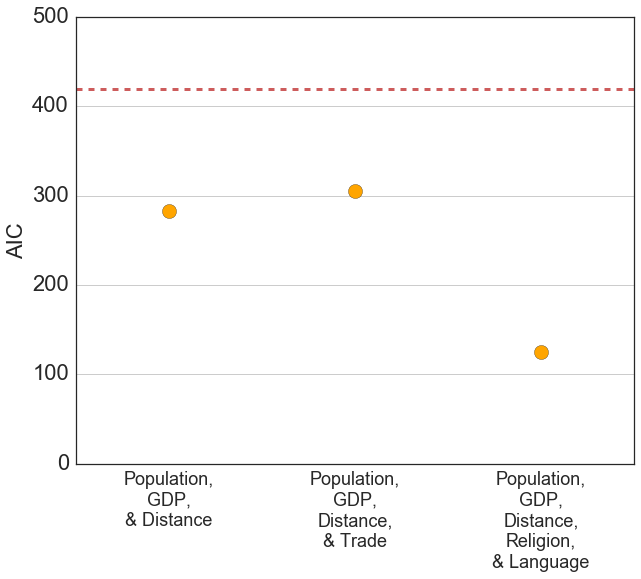

In [304]:
trend_df=pd.DataFrame(trend_aic)

plt.figure(figsize=(10,8))
ax=plt.axes()
ax.yaxis.grid(True,)

plt.hlines(xmin=-.5,xmax=len(trend_df)-1.5,y=trend_df['aic'][0],colors='indianred', linewidth=3,linestyles='--')

plt.scatter(range(len(trend_df)-1), trend_df['aic'][1:], c='orange',marker='o',s=200)

plt.ylabel('AIC',fontsize='22')
plt.xticks(range(len(trend_df)-1), trend_df['mod_name'][1:], rotation='0',fontsize=18)
plt.yticks(fontsize=22)
plt.axis([-.5, len(trend_df)-1.5, 0,500])
plt.show()

# Predicting casualties

In [325]:
cas_aic={'mod_name':[],'aic':[]}

In [326]:
casualty_df.head()
usa_search=search_pred_df3.loc[search_pred_df3['Searcher']=='United States',:].reset_index()
usa_search=pd.merge(casualty_df,usa_search,left_on='true_name',right_on='Searchee')
# Removing Liberia since Americans don't actually seem to know what it is
usa_search=usa_search.loc[usa_search.Searchee!='Liberia',:]
usa_search.head()

,true_name,resp_casualties_log10,level_0,index,Searchee,Searcher,search_score,Population,GDP (per capita PPP),com_rel,com_lang,dist,PopLog,GDP_log
0,Japan,2.382017,2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,8.103529,4.582063
1,Japan,2.419956,2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,8.103529,4.582063
2,Japan,4.954243,2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,8.103529,4.582063
3,Japan,2.416641,2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,8.103529,4.582063
4,Japan,1.698970,2,2,Japan,United States,-1.074902,126919659,38200,False,False,3.831965,8.103529,4.582063


Let's start with our raw properties model

In [327]:
md = smf.mixedlm('resp_casualties_log10~PopLog+GDP_log', usa_search, groups=usa_search['Searchee'])
mdf = md.fit() 
cas_aic['mod_name'].append('Population\n& GDP')
cas_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: resp_casualties_log10
No. Observations: 1186    Method:             REML                 
No. Groups:       38      Scale:              0.5767               
Min. group size:  25      Likelihood:         -1365.9794           
Max. group size:  37      Converged:          Yes                  
Mean group size:  31.2                                             
---------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept         3.002      0.402    7.470   0.000    2.214    3.789
PopLog            0.022      0.043    0.501   0.616   -0.063    0.107
GDP_log          -0.221      0.053   -4.152   0.000   -0.326   -0.117
Intercept RE      0.004      0.008                                   



Let's take a step back then and start with the GPD model

In [328]:
md = smf.mixedlm('resp_casualties_log10~GDP_log', usa_search, groups=usa_search['Searchee'])
mdf = md.fit() 
cas_aic['mod_name'].append('GDP')
cas_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: resp_casualties_log10
No. Observations: 1186    Method:             REML                 
No. Groups:       38      Scale:              0.5767               
Min. group size:  25      Likelihood:         -1363.8841           
Max. group size:  37      Converged:          Yes                  
Mean group size:  31.2                                             
---------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept         3.169      0.220   14.426   0.000    2.739    3.600
GDP_log          -0.221      0.053   -4.198   0.000   -0.325   -0.118
Intercept RE      0.004      0.007                                   



How about distance?

In [329]:
md = smf.mixedlm('resp_casualties_log10~GDP_log+dist', usa_search, groups=usa_search['Searchee'])
mdf = md.fit() 
cas_aic['mod_name'].append('GDP,\n& Distance')
cas_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: resp_casualties_log10
No. Observations: 1186    Method:             REML                 
No. Groups:       38      Scale:              0.5768               
Min. group size:  25      Likelihood:         -1364.9203           
Max. group size:  37      Converged:          Yes                  
Mean group size:  31.2                                             
---------------------------------------------------------------------
                 Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept         2.821      0.445    6.333   0.000    1.948    3.694
GDP_log          -0.213      0.053   -3.983   0.000   -0.318   -0.108
dist              0.085      0.094    0.899   0.369   -0.100    0.270
Intercept RE      0.004      0.008                                   



Cultural factors?

In [330]:
md = smf.mixedlm('resp_casualties_log10~GDP_log+com_rel+com_lang', usa_search, groups=usa_search['Searchee'])
mdf = md.fit() 
cas_aic['mod_name'].append('GDP,\nReligion,\n& Language')
cas_aic['aic'].append(calc_aic(mdf))
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: resp_casualties_log10
No. Observations: 1186    Method:             REML                 
No. Groups:       38      Scale:              0.5768               
Min. group size:  25      Likelihood:         -1364.8985           
Max. group size:  37      Converged:          Yes                  
Mean group size:  31.2                                             
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             3.156     0.209  15.105  0.000   2.747   3.566
com_rel[T.True]      -0.107     0.070  -1.530  0.126  -0.243   0.030
com_lang[T.True]     -0.084     0.049  -1.733  0.083  -0.179   0.011
GDP_log              -0.188     0.052  -3.636  0.000  -0.290  -0.087
Intercept RE          0.002     0.007                   

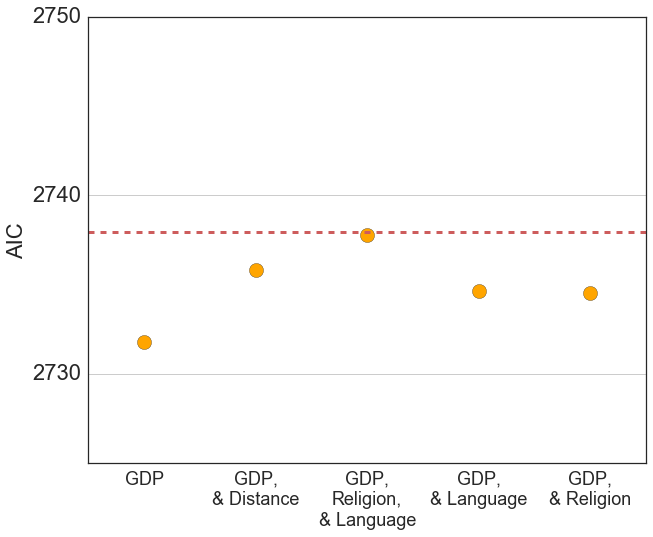

In [378]:
cas_df=pd.DataFrame(cas_aic)

plt.figure(figsize=(10,8))
ax=plt.axes()
ax.yaxis.grid(True,)

plt.hlines(xmin=-.5,xmax=len(cas_df)-1.5,y=cas_df['aic'][0],colors='indianred', linewidth=3,linestyles='--')

plt.scatter(range(len(cas_df)-1), cas_df['aic'][1:], c='orange',marker='o',s=200)

plt.ylabel('AIC',fontsize='22')
plt.xticks(range(len(cas_df)-1), cas_df['mod_name'][1:], rotation='0',fontsize=18)
plt.yticks([2730,2740,2750],fontsize=22)
plt.axis([-.5, len(cas_df)-1.5, 2725,2750])
plt.show()